In [71]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import cv2

import glob
references = glob.glob('/media/viu/DISK/clean_tif_8bit/8-bit sRGB Processed/*None_PC00C00*.tif')
references.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
references = references[:96]
references.remove('/media/viu/DISK/clean_tif_8bit/8-bit sRGB Processed/PGR Flea_0082__None_PC00C00__E0_000_1-180901-141229.tif')
references.remove('/media/viu/DISK/clean_tif_8bit/8-bit sRGB Processed/PGR Flea_0107__None_PC00C00__E0_000_1-180904-141539.tif')
references.remove('/media/viu/DISK/clean_tif_8bit/8-bit sRGB Processed/PGR Flea_0181__None_PC00C00__E0_000_1-180911-154549.tif')
references.remove('/media/viu/DISK/clean_tif_8bit/8-bit sRGB Processed/PGR Flea_0178__None_PC00C00__E0_000_2-180911-151439.tif')
ref_indexs = [int(reference.split('/')[-1].split('_')[1]) for reference in references]

tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PC00C00_*.tif')) + \
            list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PL45C00_*.tif')) + \
            list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PR45C00_*.tif'))
# tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_*C00_*.tif'))
tubimgs.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
new_tubimgs = []
for tubimg in tubimgs:
    index = int(tubimg.split('/')[-1].split('_')[1])
    if index in ref_indexs:
        new_tubimgs.append(tubimg)

tubimgs = new_tubimgs
print(len(references), len(tubimgs), len(tubimgs)/len(references))

92 270 2.9347826086956523


In [72]:
tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PC00C00_*.tif'))
tubimgs.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
new_tubimgs = []
for tubimg in tubimgs:
    index = int(tubimg.split('/')[-1].split('_')[1])
    if index in ref_indexs:
        new_tubimgs.append(index)
a_new_tubimgs = new_tubimgs
len(a_new_tubimgs)

92

In [73]:
tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PL45C00_*.tif'))
tubimgs.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
new_tubimgs = []
for tubimg in tubimgs:
    index = int(tubimg.split('/')[-1].split('_')[1])
    if index in ref_indexs:
        new_tubimgs.append(index)
b_new_tubimgs = new_tubimgs
len(b_new_tubimgs)

89

In [74]:
tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PR45C00_*.tif'))
tubimgs.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
new_tubimgs = []
for tubimg in tubimgs:
    index = int(tubimg.split('/')[-1].split('_')[1])
    if index in ref_indexs:
        new_tubimgs.append(index)
c_new_tubimgs = new_tubimgs
len(c_new_tubimgs)

89

In [75]:
tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PC00C00_*.tif')) + \
            list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PL45C00_*.tif')) + \
            list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_PR45C00_*.tif'))
# tubimgs = list(glob.glob('/media/viu/DISK/Turbulence_data/Range Stills/300m/*None_*C00_*.tif'))
tubimgs.sort(key=lambda x: int(x.split('/')[-1].split('_')[1]))
new_tubimgs = []
for tubimg in tubimgs:
    index = int(tubimg.split('/')[-1].split('_')[1])
    if index in c_new_tubimgs:
        new_tubimgs.append(tubimg)
tubimgs = new_tubimgs


In [76]:
new_references = []
for reference in references:
    index = int(reference.split('/')[-1].split('_')[1])
    if index in c_new_tubimgs:
        new_references.append(reference)
references = new_references
print(len(references), len(tubimgs), len(tubimgs)/len(references))

89 267 3.0


In [77]:
from basicsr.utils import img2tensor, tensor2img
from torchvision.transforms.functional import normalize

from facexlib.utils.face_restoration_helper import FaceRestoreHelper
face_helper = FaceRestoreHelper(
    2,
    face_size=512,
    crop_ratio=(1.2, 1.2),
    det_model='retinaface_resnet50',
    save_ext='png',
    device='cuda:0'
)

In [78]:
idx = 24
tub_face_img = cv2.imread(references[idx], cv2.IMREAD_UNCHANGED)
face_helper.clean_all()
face_helper.read_image(tub_face_img)
face_helper.get_face_landmarks_5(only_center_face=True)
face_helper.align_warp_face()
tub_face_img = face_helper.cropped_faces[0]
tub_face_img = cv2.resize(tub_face_img, (512, 512), cv2.INTER_LANCZOS4)

tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')

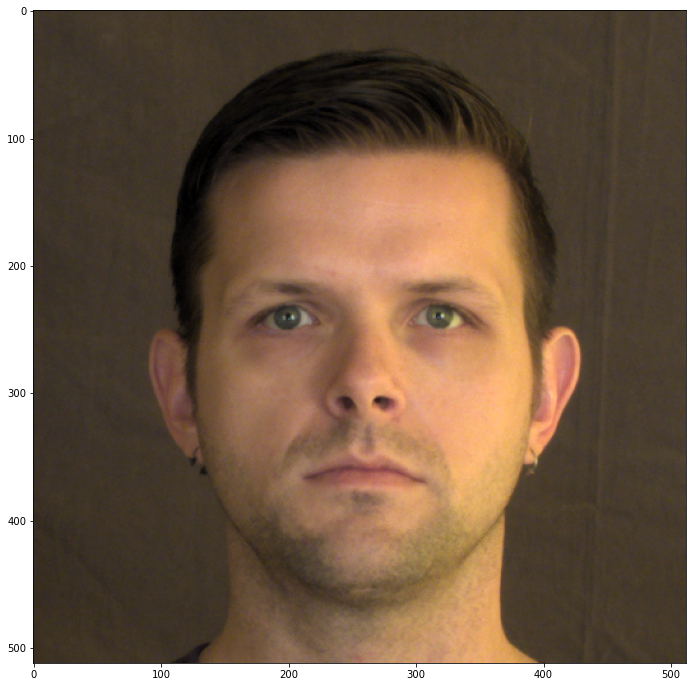

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.imshow(tensor2img(tub_face_img_th, rgb2bgr=False, min_max=(-1, 1)))

In [80]:
for index, reference in enumerate(references):
    tub_face_img = cv2.imread(reference, cv2.IMREAD_UNCHANGED)
    face_helper.clean_all()
    face_helper.read_image(tub_face_img)
    face_helper.get_face_landmarks_5(only_center_face=True)
    face_helper.align_warp_face()
    tub_face_img = face_helper.cropped_faces[0]
    tub_face_img = cv2.resize(tub_face_img, (512, 512), cv2.INTER_LANCZOS4)

    tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
    normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
    tub_face_img = tensor2img(tub_face_img_th, rgb2bgr=True, min_max=(-1, 1))
    cv2.imwrite(os.path.join('/data/datasets/Turbulence/Tubfaces95/references/', '%02d.png' % (index+1)), tub_face_img)

In [81]:
import numpy as np
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

# raw_tub_face_imgs = []
# for index, tubimg in enumerate(tubimgs):
#     if tubimg == '/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0107__None_PC00C00__R1_000_1-180904-135334.tif':
#         tubimg = '/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0107__None_PL45C00__R1_000_1-180904-135414.tif'
#     raw_tub_face_img = tub_face_img = cv2.imread(tubimg, cv2.IMREAD_UNCHANGED).astype(np.float32)
#     raw_tub_face_imgs.append(raw_tub_face_img)
# raw_tub_face_imgs = np.concatenate(raw_tub_face_imgs, axis=0).reshape((-1, 3))
# raw_tub_face_imgs_max = np.max(raw_tub_face_imgs, 0)
# raw_tub_face_imgs_min = np.min(raw_tub_face_imgs, 0)

for index, tubimg in enumerate(tubimgs):
    # if tubimg == '/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0107__None_PC00C00__R1_000_1-180904-135334.tif':
    #     tubimg = '/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0107__None_PL45C00__R1_000_1-180904-135414.tif'
    tub_face_img = cv2.imread(tubimg, cv2.IMREAD_UNCHANGED).astype(np.float32)
    # a TRICK
    tub_face_img = np.uint8(((tub_face_img - tub_face_img.min()) / (tub_face_img.max() - tub_face_img.min())) * 255.)
    tub_face_img = adjust_gamma(tub_face_img, 2.6)
    tub_face_img = cv2.GaussianBlur(tub_face_img, (3,3), cv2.BORDER_DEFAULT)
    tub_face_img = np.clip(tub_face_img, 0, 255)
    # face_helper.clean_all()
    # face_helper.read_image(tub_face_img)
    # face_helper.get_face_landmarks_5(only_center_face=True)
    # face_helper.align_warp_face()
    # tub_face_img = face_helper.cropped_faces[0]
    # tub_face_img = cv2.resize(tub_face_img, (512, 512), cv2.INTER_LANCZOS4)

    # tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
    # normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    # tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
    # tub_face_img = tensor2img(tub_face_img_th, rgb2bgr=True, min_max=(-1, 1))
    # denoised_tub_face_img = cv2.fastNlMeansDenoisingColored(tub_face_img,None,4,4,7,21)
    
    
    # cv2.imwrite(os.path.join('/data/datasets/Tubfaces95/tubimages/', '%02d.png' % (index+1)), denoised_tub_face_img)
    print(tubimg, index+1)
    cv2.imwrite(os.path.join('/data/datasets/Turbulence/Tubfaces95/300M/tone_mapping_tubimages', '%03d.png' % (index+1)), tub_face_img)

/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0013__None_PC00C00__R1_000_1-180918-074434.tif 1
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0013__None_PL45C00__R1_000_1-180918-074509.tif 2
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0013__None_PR45C00__R1_000_1-180918-074730.tif 3
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0017__None_PC00C00__R1_000_1-180825-175611.tif 4
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0017__None_PL45C00__R1_000_1-180825-175650.tif 5
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0017__None_PR45C00__R1_000_1-180825-175916.tif 6
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0099__None_PC00C00__R1_000_1-180902-155954.tif 7
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0099__None_PL45C00__R1_000_1-180902-160038.tif 8
/media/viu/DISK/Turbulence_data/Range Stills/300m/Victorem_0099__None_PR45C00__R1_000_1-180902-160340.tif 9
/media/viu/DISK/Turbulence_d